In [1]:
import gym
import minerl

/Users/ashe/.local/share/virtualenvs/MineRL-APCPXVva/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [2]:
import tqdm
import numpy as np
from sklearn.cluster import KMeans

In [3]:
import logging
logging.basicConfig(level=logging.DEBUG)  # ログを見れる
# import coloredlogs
# coloredlogs.install(logging.INFO)

In [4]:
def random():
    env = gym.make('MineRLNavigateDense-v0')

    # set the environment to allow interactive connections on port 6666
    # and slow the tick speed to 6666.
    env.make_interactive(port=6666, realtime=True)

    obs = env.reset()
    done = False
    while not done:
        action = env.action_space.sample()  # ランダムに動く
        obs, reward, done, _ = env.step(action)
        env.render()

In [5]:
def target():
    env = gym.make('MineRLNavigateDense-v0')
    # import datetime  # 開発用
    # env = gym.wrappers.Monitor(env, "/Users/ashe/workspace/Creation/Capture/" + datetime.datetime.now().isoformat())  # 記録用

    env.make_interactive(port=6666, realtime=True)
    obs  = env.reset()
    done = False
    net_reward = 0
    while not done:  # 目的地に向かって動く
        action = env.action_space.noop()

        action['camera'] = [0, 0.03*obs["compassAngle"]]
        action['back'] = 0
        action['forward'] = 1
        action['jump'] = 0
        action['attack'] = 1

        obs, reward, done, info = env.step(action)
        env.render()

        net_reward += reward
        print("Total reward: ", net_reward)

In [6]:
def kmeans():

    # dat = minerl.data.make('MineRLTreechopVectorObf-v0')  # $ MINERL_DATA_ROOT="/Users/ashe/workspace/MineRL/data"
    dat = minerl.data.make('MineRLTreechopVectorObf-v0', data_dir="/Users/ashe/workspace/MineRL/data")
    # dat = minerl.data.make('MineRLNavigateVectorObf-v0', data_dir="/Users/ashe/workspace/MineRL/data")
    # dat = minerl.data.make('MineRLObtainDiamondVectorObf-v0', data_dir="/Users/ashe/workspace/MineRL/data")

    act_vectors = []
    NUM_CLUSTERS = 4

    # Load the dataset storing 1000 batches of actions
    for _, act, _, _, _ in tqdm.tqdm(dat.batch_iter(16, 32, 2, preload_buffer_size=20)):
        act_vectors.append(act['vector'])
        if len(act_vectors) > 1000:
            break

    # Reshape these the action batches
    acts = np.concatenate(act_vectors).reshape(-1, 64)
    kmeans_acts = acts[:100000]  # 使う情報は100000個のみ

    # Use sklearn to cluster the demonstrated actions
    kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=0).fit(kmeans_acts)
    print ('Distortion: %.2f'% kmeans.inertia_)  # 小さい方がいい（としか言えない）．0が最適


    # 図やグラフを図示するためのライブラリをインポートする。
    # import matplotlib
    # matplotlib.use('TkAgg')  # 古いバージョンだとbackend: macosxに対応していないので，指定し直す
    import matplotlib.pyplot as plt
    from pandas import plotting # 高度なプロットを行うツールのインポート
    #import sklearn #機械学習のライブラリ
    from sklearn.decomposition import PCA #主成分分析器
    labels = kmeans.labels_
    #主成分分析の実行
    # 64次元特徴を2次元にする
    pca = PCA(n_components=2)
    pca.fit(kmeans_acts)
    pca_data = pca.fit_transform(kmeans_acts)

    from colorsys import hls_to_rgb
    def get_distinct_colors(n):
        colors = []
        for i in np.arange(0., 360., 360. / n):
            h = i / 360.
            l = (50 + np.random.rand() * 10) / 100.
            s = (90 + np.random.rand() * 10) / 100.
            colors.append(hls_to_rgb(h, l, s))
        return colors
    
    # それぞれに与える色を決める。
    color_codes = get_distinct_colors(NUM_CLUSTERS)
    # サンプル毎に色を与える。
    colors = [color_codes[x] for x in labels]
    # クラスタリング結果のプロット
    plt.figure()
    plt.scatter(pca_data[:,0], pca_data[:,1], c=colors)
    # for i in range(pca_data.shape[0]):  # 上と同じ
    #     plt.scatter(pca_data[i,0], pca_data[i,1], c=color_codes[int(labels[i])])
    plt.title("Principal Component Analysis")
    plt.xlabel("The first principal component score")
    plt.ylabel("The second principal component score")
    plt.savefig("dpi_scatter.png", format="png", dpi=300)
    plt.show()


    i, net_reward, done, env = 0, 0, False, gym.make('MineRLTreechopVectorObf-v0')
    env.make_interactive(port=6666, realtime=True)
    obs = env.reset()

    while not done:
        # Let's use a frame skip of 4 (could you do better than a hard-coded frame skip?)
        if i % 4 == 0:
            action = {  # 変えてもダメ
                # 'vector': kmeans.cluster_centers_[np.random.choice(NUM_CLUSTERS)] # 4フレームごとにクラスタリングした行動のどれかを選択する
                'vector': kmeans.cluster_centers_[(int)((i/4) % NUM_CLUSTERS)]  # 4フレームごとにクラスタリングした行動を順にとる
            }

            obs, reward, done, info = env.step(action)  # actionを組み込みのものにしてもダメ
            # random_act = env.action_space.noop()
            
            # random_act['camera'] = [0, 0.1*obs["compassAngle"]]
            # random_act['back'] = 0
            # random_act['forward'] = 1
            # random_act['jump'] = 1
            # random_act['attack'] = 1
            # obs, reward, done, info = env.step(random_act)

            # env.render()

            if reward > 0:
                print("+{} reward!".format(reward))
            net_reward += reward
        i += 1

    print("Total reward: ", net_reward)

In [7]:
def no_op_test():
    env = gym.make("MineRLTreechopVectorObf-v0")
    while True:
        obs = env.reset()
        done= False
        while not done:
            x = env.env_spec.wrap_action(env.env_spec.env_to_wrap.env_to_wrap.action_space.no_op())
            print(x)
            a,r,done,i = env.step(x) # Also happens if you try to feed in {'vector': np.random.random((64,))}
            env.render()

In [8]:
def simple_env_test():
    """
    Tests running a simple environment.
    """
    NUM_EPISODES=1
    env = gym.make('MineRLNavigateDense-v0')
    
    actions = [env.action_space.sample() for _ in range(2000)]
    xposes = []
    env.seed(25)
    for _ in range(NUM_EPISODES):
        obs = env.reset()
        done = False
        netr = 0
        while not done:
            random_act = env.action_space.noop()
            
            random_act['camera'] = [0, 0.1*obs["compassAngle"]]  # compassAngleはNavigationのみ
            random_act['back'] = 0
            random_act['forward'] = 1
            random_act['jump'] = 1
            random_act['attack'] = 1
            obs, reward, done, info = env.step(
                random_act)
            netr += reward
            print(reward, netr)
            env.render()
    print("Demo complete.")

In [9]:
def simple_treechop_test():  # env.resetでエラー
    """
    Tests running a simple environment.
    """
    NUM_EPISODES=6
    env = gym.make('MineRLTreechop-v0')  # データセットが悪さしてそう
    
    actions = [env.action_space.sample() for _ in range(2000)]
    xposes = []
    for i in range(NUM_EPISODES):
        env.seed(i)
        obs = env.reset()  # 実行できてもTypeError: a bytes-like object is required, not 'NoneType'
        done = False
        netr = 0
        for _ in range(i):
            random_act = env.action_space.noop()
            # random_act['camera'] = [0, 0.1]
            # random_act['back'] = 0
            # random_act['forward'] = 1
            # random_act['jump'] = 1
            obs, reward, done, info = env.step(
                random_act)
            netr += reward
            print(reward, netr)
            env.render()
    print("Demo complete.")

In [10]:
def seed_test():
    """
    Tests running a simple environment.
    """
    NUM_EPISODES=10
    env = gym.make('MineRLNavigateDense-v0')  # MineRLTreechop-v0で動く？
    
    actions = [env.action_space.sample() for _ in range(2000)]
    xposes = []
    reward_list = []
    for _ in range(NUM_EPISODES):
        env.seed(22)
        obs = env.reset()  # 木にぶつかってTypeError: a bytes-like object is required, not 'NoneType'  ループが悪そう！
        done = False
        netr = 0
        rewards = []
        while not done and  len(rewards) < 50:
            random_act = env.action_space.noop()
            # if(len(rewards) > 50):
            
            random_act['camera'] = [0, 0.1]
            random_act['back'] = 0
            random_act['forward'] = 1
            random_act['jump'] = 1
            random_act['attack'] = 1
            # print(random_act)
            obs, reward, done, info = env.step(
                random_act)
            env.render()
            rewards.append(reward)
            netr += reward
            # print(reward, netr)
        reward_list.append(rewards)
    import matplotlib.pyplot as plt
    for t in range(NUM_EPISODES):
        plt.plot(np.cumsum(reward_list[t]))
    # plt.plot(np.cumsum(reward_list[1]))
    plt.show()
    # from IPython import embed; embed()
    input()
    print("Demo complete.")

In [11]:
def data_check():
    # Sample some data from the dataset!
    data = minerl.data.make("MineRLTreechopVectorObf-v0", data_dir="/Users/ashe/workspace/MineRL/data")

    # Iterate through batches of data
    counter = 0
    # batch_size: データの個数（=行数）, seq_len: 各データのステップ（フレーム）数（=列数）, rew=reward（報酬）
    for obs,  act, rew,  next_obs, done in data.batch_iter(batch_size=2, seq_len=5, num_epochs=1):
        # Do something
        correct_len = len(rew)
        # print("Obs shape:", obs)  # pov, vector
        print("Act shape:", act)  # vector
        # print("Rew shape:", rew)
        # print("Done shape:", done)
        # print(counter + 1)
        # counter += 1

In [12]:
def kmeans_check():
    dat = minerl.data.make("MineRLTreechopVectorObf-v0", data_dir="/Users/ashe/workspace/MineRL/data")
    act_vectors = []
    NUM_CLUSTERS = 30

    # Load the dataset storing 1000 batches of actions
    for _, act, _, _, _ in tqdm.tqdm(dat.batch_iter(3, 32, 2)):
        act_vectors.append(act['vector'])
        print(len(act_vectors))
        if len(act_vectors) > 100:
            break

    # print(act_vectors)  # 行列のリスト
    print(np.concatenate(act_vectors).shape)  # 行列に変換
    # Reshape these the action batches
    acts = np.concatenate(act_vectors).reshape(-1, 64)
    print(acts.shape) # 時系列情報は消える

0it [00:00, ?it/s]
100%|██████████| 209/209 [00:00<00:00, 2725.39it/s]DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_juvenile_apple_angel-7_134699-136856
DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_unselfish_blood_orange_savage-17_574-3102
DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_svelte_cherry_devil-12_14807-16441
DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_excellent_pluot_behemoth-11_11013-13589
DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_subtle_iceberg_lettuce_nymph-2_35368-37243
DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_familiar_endive_ghost-2_48848-50816
DEBUG:minerl.

101it [00:13, 22.36it/s]DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_svelte_cherry_devil-12_32232-34778
DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_virtuous_mustard_greens_raven_spirit-8_9171-11677
105it [00:14, 13.59it/s]DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_absolute_grape_changeling-16_2277-4441
109it [00:14, 13.77it/s]DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_juvenile_apple_angel-7_94164-95806
DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_subtle_iceberg_lettuce_nymph-6_2150-3772
DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_absolute_zucchini_basilisk-14_164-2866
119it

DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_excellent_pluot_behemoth-11_36242-38653
305it [00:30, 13.18it/s]DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_colorless_mung_bean_dragon-19_716-3781
308it [00:30, 15.53it/s]DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_juvenile_apple_angel-7_28694-30621
DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_svelte_cherry_devil-12_7855-10004
311it [00:31,  8.11it/s]DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_hideous_breadfruit_golum-6_308-2269
319it [00:31, 11.83it/s]DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_unselfish_blood_orange_savage-14_134

DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_subtle_iceberg_lettuce_nymph-2_33106-35301
501it [00:46, 11.30it/s]DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_virtuous_mustard_greens_raven_spirit-8_11795-15434
506it [00:46, 11.69it/s]DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_rigid_mustard_greens_monster-25_71932-73486
509it [00:47,  7.71it/s]DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_subtle_iceberg_lettuce_nymph-15_2332-4311
511it [00:47,  7.94it/s]DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_subtle_iceberg_lettuce_nymph-7_2063-3996
DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3

DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_unselfish_blood_orange_savage-8_852-3484
703it [01:03, 10.68it/s]DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_excellent_mango_beast-18_460-3047
705it [01:04,  7.92it/s]DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_excellent_pluot_behemoth-11_24005-26842
710it [01:04,  9.82it/s]DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_unhappy_peach_horror-6_27770-29900
715it [01:04, 12.66it/s]DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_content_squash_angel-3_5349-7498
718it [01:05, 12.59it/s]DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_quiet_mandari

DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_absolute_grape_changeling-16_149-2199
DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_agonizing_kale_tree_nymph-4_34066-35739
DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_ready_wasabi_orc-9_4623-7128
DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_alarming_arugula_medusa-2_942-3139
DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_unselfish_blood_orange_savage-13_6464-8558
DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_unselfish_blood_orange_savage-14_19453-21012
DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/Mi

Distortion: 1001.67


DEBUG:matplotlib:CACHEDIR=/Users/ashe/.matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /Users/ashe/.matplotlib/fontlist-v300.json
DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_absolute_zucchini_basilisk-13_161-3252
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_subtle_iceberg_lettuce_nymph-6_6100-8068
DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_juvenile_apple_angel-7_108223-109900
DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_content_squash_angel-3_5349-7498
DEBUG:matplotlib.axes._base:update_title_pos
DE

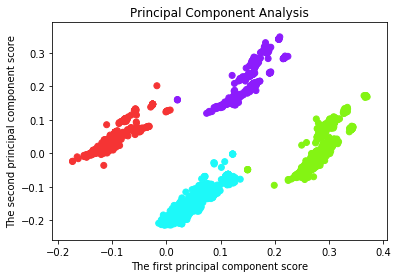

DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_excellent_pluot_behemoth-11_56888-59772
DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_agonizing_kale_tree_nymph-7_101940-103636
DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_juvenile_apple_angel-7_28694-30621
DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_content_squash_angel-3_3594-5309
DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_familiar_endive_ghost-2_42839-44666
INFO:minerl.env.malmo.instance.d90b64:Starting Minecraft process: ['/var/folders/s0/wc1rzmgd4412_bssv_bvdz2r0000gn/T/tmpaagb4717/Minecraft/launchClient.sh', '-port', '11993', '-env', '-runDir', '/var/folders/s0/wc1rzmgd4412_bssv_bvdz2r0000gn/T/

DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_anxious_lemon_lake_spirit-1_87882-89694
DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_alarming_arugula_medusa-2_3311-5067
DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_absolute_grape_changeling-15_15331-17395
DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_familiar_endive_ghost-2_613-2838
DEBUG:minerl.env.malmo.instance.d90b64::applyBinaryPatches
DEBUG:minerl.env.malmo.instance.d90b64::extractDependencyATs SKIPPED
DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_hideous_breadfruit_golum-6_308-2269
DEBUG:minerl.env.malmo.instance.d90b64::extractMcpData SKIPPED
DEBUG:minerl.env.malmo.instance.d90b64::extractMcpMap

DEBUG:minerl.env.malmo.instance.d90b64:注意:ObfuscationServiceMCP supports type: "searge"
DEBUG:minerl.env.malmo.instance.d90b64:注意:ObfuscationServiceMCP supports type: "notch"
DEBUG:minerl.env.malmo.instance.d90b64:注意:Loading searge mappings from /Users/ashe/.gradle/caches/minecraft/de/oceanlabs/mcp/mcp_snapshot/20161220/1.11.2/srgs/mcp-srg.srg
DEBUG:minerl.env.malmo.instance.d90b64:注意:Loading notch mappings from /Users/ashe/.gradle/caches/minecraft/de/oceanlabs/mcp/mcp_snapshot/20161220/1.11.2/srgs/mcp-notch.srg
DEBUG:minerl.env.malmo.instance.d90b64:注意:Writing refmap to /private/var/folders/s0/wc1rzmgd4412_bssv_bvdz2r0000gn/T/tmpaagb4717/Minecraft/build/tmp/compileJava/compileJava-refmap.json
DEBUG:minerl.env.malmo.instance.d90b64:注意:Writing refmap to /private/var/folders/s0/wc1rzmgd4412_bssv_bvdz2r0000gn/T/tmpaagb4717/Minecraft/build/tmp/compileJava/compileJava-refmap.json
DEBUG:minerl.env.malmo.instance.d90b64:注意:Writing searge output SRGs to /private/var/folders/s0/wc1rzmgd4412_bss

DEBUG:minerl.env.malmo.instance.d90b64:[13:27:36] [main/INFO]: Calling tweak class net.minecraftforge.fml.relauncher.CoreModManager$FMLPluginWrapper
DEBUG:minerl.env.malmo.instance.d90b64:[13:27:36] [main/INFO]: Calling tweak class org.spongepowered.asm.mixin.EnvironmentStateTweaker
DEBUG:minerl.env.malmo.instance.d90b64:[13:27:36] [main/INFO]: Initialised Mixin FML Remapper Adapter with net.minecraftforge.fml.common.asm.transformers.deobf.FMLDeobfuscatingRemapper@438bad7c
DEBUG:minerl.env.malmo.instance.d90b64:[13:27:36] [main/INFO]: Calling tweak class net.minecraftforge.fml.common.launcher.FMLDeobfTweaker
DEBUG:minerl.env.malmo.instance.d90b64:[13:27:37] [main/INFO]: Calling tweak class net.minecraftforge.gradle.tweakers.AccessTransformerTweaker
DEBUG:minerl.env.malmo.instance.d90b64:[13:27:37] [main/INFO]: Loading tweak class name net.minecraftforge.fml.common.launcher.TerminalTweaker
DEBUG:minerl.env.malmo.instance.d90b64:[13:27:37] [main/INFO]: Calling tweak class net.minecraftfo

DEBUG:minerl.env.malmo.instance.d90b64:[13:27:44] [Client thread/INFO]: Applying holder lookups
DEBUG:minerl.env.malmo.instance.d90b64:[13:27:44] [Client thread/INFO]: Holder lookups applied
DEBUG:minerl.env.malmo.instance.d90b64:[13:27:44] [Client thread/INFO]: Configured a dormant chunk cache size of 0
DEBUG:minerl.env.malmo.instance.d90b64:[13:27:44] [Forge Version Check/INFO]: [forge] Starting version check at http://files.minecraftforge.net/maven/net/minecraftforge/forge/promotions_slim.json
DEBUG:minerl.env.malmo.instance.d90b64:[13:27:44] [Client thread/INFO]: [STDOUT]: Testing schemas against internal version number: 0.37
DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_equal_olive_chimera-7_2237-4122
DEBUG:minerl.env.malmo.instance.d90b64:[13:27:44] [Client thread/INFO]: [STDOUT]: [LOGTOPY] Performance directory not specified.
DEBUG:minerl.env.malmo.instance.d90b64:[13:27:44] [Client thread/INFO]: [STDOUT]: [ERRO

DEBUG:minerl.env.malmo.instance.d90b64:[13:27:51] [Sound Library Loader/INFO]: Sound engine started
DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_juvenile_apple_angel-7_115834-117438
DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_glistening_okra_golum-9_200181-202384
DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_failing_soybean_werewolf-1_7697-9500
DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreechopVectorObf-v0/v3_juvenile_apple_angel-7_99815-101515
DEBUG:minerl.env.malmo.instance.d90b64:[13:27:52] [Client thread/INFO]: Max texture size: 16384
DEBUG:minerl.env.malmo.instance.d90b64:[13:27:52] [Client thread/INFO]: Created: 512x512 textures-atlas
DEBUG:minerl.data.data_pipeline:Loading from file /Users/ashe/workspace/MineRL/data/MineRLTreech

DEBUG:minerl.env.malmo.instance.d90b64:[13:28:04] [Server thread/INFO]: Changing view distance to 4, from 10
DEBUG:minerl.env.malmo.instance.d90b64:[13:28:05] [Netty Local Client IO #0/INFO]: [STDOUT]: Transformed Name: net.minecraft.client.entity.EntityOtherPlayerMP
DEBUG:minerl.env.malmo.instance.d90b64:[13:28:05] [Netty Local Client IO #0/INFO]: [STDOUT]: MALMO: Attempting to transform MinecraftServer
DEBUG:minerl.env.malmo.instance.d90b64:[13:28:05] [Netty Local Client IO #0/INFO]: [STDOUT]: MALMO: Found EntityOtherPlayerMP, attempting to transform it
DEBUG:minerl.env.malmo.instance.d90b64:[13:28:05] [Server thread/INFO]: [STDOUT]: SERVER request state: WAITING_FOR_MOD_READY
DEBUG:minerl.env.malmo.instance.d90b64:[13:28:05] [Server thread/INFO]: [STDOUT]: CLIENT request state: WAITING_FOR_SERVER_READY
DEBUG:minerl.env.malmo.instance.d90b64:[13:28:05] [Server thread/INFO]: [STDOUT]: SERVER enter state: WAITING_FOR_MOD_READY
DEBUG:minerl.env.malmo.instance.d90b64:[13:28:05] [Netty Lo

DEBUG:minerl.env.malmo.instance.d90b64:	at org.gradle.api.internal.tasks.execution.ExecuteActionsTaskExecuter.execute(ExecuteActionsTaskExecuter.java:46)
DEBUG:minerl.env.malmo.instance.d90b64:	at org.gradle.api.internal.tasks.execution.PostExecutionAnalysisTaskExecuter.execute(PostExecutionAnalysisTaskExecuter.java:35)
DEBUG:minerl.env.malmo.instance.d90b64:	at org.gradle.api.internal.tasks.execution.SkipUpToDateTaskExecuter.execute(SkipUpToDateTaskExecuter.java:66)
DEBUG:minerl.env.malmo.instance.d90b64:	at org.gradle.api.internal.tasks.execution.ValidatingTaskExecuter.execute(ValidatingTaskExecuter.java:58)
DEBUG:minerl.env.malmo.instance.d90b64:	at org.gradle.api.internal.tasks.execution.SkipEmptySourceFilesTaskExecuter.execute(SkipEmptySourceFilesTaskExecuter.java:52)
DEBUG:minerl.env.malmo.instance.d90b64:	at org.gradle.api.internal.tasks.execution.SkipTaskWithNoActionsExecuter.execute(SkipTaskWithNoActionsExecuter.java:52)
DEBUG:minerl.env.malmo.instance.d90b64:	at org.gradle.ap

DEBUG:minerl.env.malmo.instance.d90b64:Caused by: org.gradle.process.internal.ExecException: Process 'command '/Library/Java/JavaVirtualMachines/adoptopenjdk-8.jdk/Contents/Home/bin/java'' finished with non-zero exit value 134
DEBUG:minerl.env.malmo.instance.d90b64:	at org.gradle.process.internal.DefaultExecHandle$ExecResultImpl.assertNormalExitValue(DefaultExecHandle.java:367)
DEBUG:minerl.env.malmo.instance.d90b64:	at org.gradle.process.internal.DefaultJavaExecAction.execute(DefaultJavaExecAction.java:31)
DEBUG:minerl.env.malmo.instance.d90b64:	at org.gradle.api.tasks.JavaExec.exec(JavaExec.java:74)
DEBUG:minerl.env.malmo.instance.d90b64:	at org.gradle.internal.reflect.JavaMethod.invoke(JavaMethod.java:75)
DEBUG:minerl.env.malmo.instance.d90b64:	at org.gradle.api.internal.project.taskfactory.AnnotationProcessingTaskFactory$StandardTaskAction.doExecute(AnnotationProcessingTaskFactory.java:228)
DEBUG:minerl.env.malmo.instance.d90b64:	at org.gradle.api.internal.project.taskfactory.Annot

DEBUG:minerl.env.malmo.instance.82e6f9:注意:一部の入力ファイルは非推奨のAPIを使用またはオーバーライドしています。
DEBUG:minerl.env.malmo.instance.82e6f9:注意:詳細は、-Xlint:deprecationオプションを指定して再コンパイルしてください。
DEBUG:minerl.env.malmo.instance.82e6f9:注意:入力ファイルの操作のうち、未チェックまたは安全ではないものがあります。
DEBUG:minerl.env.malmo.instance.82e6f9:注意:詳細は、-Xlint:uncheckedオプションを指定して再コンパイルしてください。
DEBUG:minerl.env.malmo.instance.82e6f9:
DEBUG:minerl.env.malmo.instance.82e6f9::processResources
DEBUG:minerl.env.malmo.instance.82e6f9::classes
DEBUG:minerl.env.malmo.instance.82e6f9::jar
DEBUG:minerl.env.malmo.instance.82e6f9::extractNatives SKIPPED
DEBUG:minerl.env.malmo.instance.82e6f9::getAssetIndex UP-TO-DATE
DEBUG:minerl.env.malmo.instance.82e6f9::getAssets
DEBUG:minerl.env.malmo.instance.82e6f9::makeStart SKIPPED
DEBUG:minerl.env.malmo.instance.82e6f9::runClient
DEBUG:minerl.env.malmo.instance.82e6f9:[13:28:53] [main/INFO]: Extra: []
DEBUG:minerl.env.malmo.instance.82e6f9:[13:28:53] [main/INFO]: Found and added coremod: com.microsoft.Malmo.OverclockingP

DEBUG:minerl.env.malmo.instance.82e6f9:[13:28:55] [main/INFO]: [com.microsoft.Malmo.OverclockingClassTransformer:transform:42]: Transformed Name: net.minecraft.client.entity.EntityPlayerSP
DEBUG:minerl.env.malmo.instance.82e6f9:[13:28:55] [main/INFO]: [com.microsoft.Malmo.OverclockingClassTransformer:transform:42]: Transformed Name: net.minecraft.client.entity.AbstractClientPlayer
DEBUG:minerl.env.malmo.instance.82e6f9:[13:28:55] [Client thread/INFO]: Setting user: Player757
DEBUG:minerl.env.malmo.instance.82e6f9:[13:28:58] [Client thread/WARN]: Skipping bad option: lastServer:
DEBUG:minerl.env.malmo.instance.82e6f9:[13:28:58] [Client thread/INFO]: LWJGL Version: 2.9.2
DEBUG:minerl.env.malmo.instance.82e6f9:[13:28:58] [Client thread/INFO]: [STDOUT]: MALMO: Attempting to transform MinecraftServer
DEBUG:minerl.env.malmo.instance.82e6f9:[13:28:58] [Client thread/INFO]: [STDOUT]: MALMO: Found GlStateManager, attempting to transform it
DEBUG:minerl.env.malmo.instance.82e6f9:[13:28:58] [Clie

DEBUG:minerl.env.malmo.instance.82e6f9:[13:29:04] [Client thread/WARN]: ResourcePack: ignored non-lowercase namespace: MalmoMod in /private/var/folders/s0/wc1rzmgd4412_bssv_bvdz2r0000gn/T/tmpfhy18ha2/Minecraft/build/libs/MalmoMod-0.37.0.jar
DEBUG:minerl.env.malmo.instance.82e6f9:[13:29:04] [Client thread/WARN]: ResourcePack: ignored non-lowercase namespace: MalmoMod in /private/var/folders/s0/wc1rzmgd4412_bssv_bvdz2r0000gn/T/tmpfhy18ha2/Minecraft/build/libs/MalmoMod-0.37.0.jar
DEBUG:minerl.env.malmo.instance.82e6f9:[13:29:05] [Client thread/INFO]: SoundSystem shutting down...
DEBUG:minerl.env.malmo.instance.82e6f9:[13:29:05] [Client thread/WARN]: Author: Paul Lamb, www.paulscode.com
DEBUG:minerl.env.malmo.instance.82e6f9:[13:29:05] [Sound Library Loader/INFO]: Starting up SoundSystem...
DEBUG:minerl.env.malmo.instance.82e6f9:[13:29:05] [Thread-7/INFO]: Initializing LWJGL OpenAL
DEBUG:minerl.env.malmo.instance.82e6f9:[13:29:05] [Thread-7/INFO]: (The LWJGL binding of OpenAL.  For more in

DEBUG:minerl.env.malmo.instance.82e6f9:[13:29:25] [Client thread/INFO]: [STDOUT]: CLIENT enter state: WAITING_FOR_SERVER_READY
DEBUG:minerl.env.malmo.instance.82e6f9:[13:29:25] [Netty Local Client IO #0/INFO]: [STDOUT]: Transformed Name: net.minecraft.client.entity.EntityOtherPlayerMP
DEBUG:minerl.env.malmo.instance.82e6f9:[13:29:25] [Netty Local Client IO #0/INFO]: [STDOUT]: MALMO: Attempting to transform MinecraftServer
DEBUG:minerl.env.malmo.instance.82e6f9:[13:29:25] [Netty Local Client IO #0/INFO]: [STDOUT]: MALMO: Found EntityOtherPlayerMP, attempting to transform it
DEBUG:minerl.env.malmo.instance.82e6f9:[13:29:25] [Server thread/INFO]: [STDOUT]: SERVER request state: DORMANT
DEBUG:minerl.env.malmo.instance.82e6f9:[13:29:25] [Server thread/INFO]: [STDOUT]: SERVER enter state: DORMANT
DEBUG:minerl.env.malmo.instance.82e6f9:[13:29:25] [Server thread/INFO]: [STDOUT]: INCOMING MISSION: Received MissionInit directly through ServerStateMachine constructor.
DEBUG:minerl.env.malmo.insta

DEBUG:minerl.env.malmo.instance.82e6f9:	at org.gradle.execution.taskgraph.DefaultTaskGraphExecuter$EventFiringTaskWorker.execute(DefaultTaskGraphExecuter.java:185)
DEBUG:minerl.env.malmo.instance.82e6f9:	at org.gradle.execution.taskgraph.AbstractTaskPlanExecutor$TaskExecutorWorker.processTask(AbstractTaskPlanExecutor.java:66)
DEBUG:minerl.env.malmo.instance.82e6f9:	at org.gradle.execution.taskgraph.AbstractTaskPlanExecutor$TaskExecutorWorker.run(AbstractTaskPlanExecutor.java:50)
DEBUG:minerl.env.malmo.instance.82e6f9:	at org.gradle.execution.taskgraph.DefaultTaskPlanExecutor.process(DefaultTaskPlanExecutor.java:25)
DEBUG:minerl.env.malmo.instance.82e6f9:	at org.gradle.execution.taskgraph.DefaultTaskGraphExecuter.execute(DefaultTaskGraphExecuter.java:110)
DEBUG:minerl.env.malmo.instance.82e6f9:	at org.gradle.execution.SelectedTaskExecutionAction.execute(SelectedTaskExecutionAction.java:37)
DEBUG:minerl.env.malmo.instance.82e6f9:	at org.gradle.execution.DefaultBuildExecuter.execute(Defau

DEBUG:minerl.env.malmo.instance.82e6f9:	at org.gradle.api.internal.AbstractTask$TaskActionWrapper.execute(AbstractTask.java:604)
DEBUG:minerl.env.malmo.instance.82e6f9:	at org.gradle.api.internal.tasks.execution.ExecuteActionsTaskExecuter.executeAction(ExecuteActionsTaskExecuter.java:80)
DEBUG:minerl.env.malmo.instance.82e6f9:	at org.gradle.api.internal.tasks.execution.ExecuteActionsTaskExecuter.executeActions(ExecuteActionsTaskExecuter.java:61)
DEBUG:minerl.env.malmo.instance.82e6f9:	... 60 more
DEBUG:minerl.env.malmo.instance.82e6f9:
DEBUG:minerl.env.malmo.instance.82e6f9:
DEBUG:minerl.env.malmo.instance.82e6f9:BUILD FAILED
DEBUG:minerl.env.malmo.instance.82e6f9:
DEBUG:minerl.env.malmo.instance.82e6f9:Total time: 58.555 secs
DEBUG:minerl.env.comms:Pause complete.
DEBUG:minerl.env.core:Sending mission init!
ERROR:minerl.env.core:Failed to reset (socket error), trying again!
ERROR:minerl.env.core:Cleaning connection! Something must have gone wrong.
DEBUG:minerl.env.comms:Pause before r

DEBUG:minerl.env.malmo.instance.b4842d:[13:30:16] [main/INFO]: Loading tweak class name net.minecraftforge.fml.common.launcher.FMLTweaker
DEBUG:minerl.env.malmo.instance.b4842d:[13:30:16] [main/INFO]: Using primary tweak class name net.minecraftforge.fml.common.launcher.FMLTweaker
DEBUG:minerl.env.malmo.instance.b4842d:[13:30:16] [main/INFO]: Loading tweak class name net.minecraftforge.gradle.tweakers.CoremodTweaker
DEBUG:minerl.env.malmo.instance.b4842d:[13:30:16] [main/INFO]: Calling tweak class net.minecraftforge.fml.common.launcher.FMLTweaker
DEBUG:minerl.env.malmo.instance.b4842d:[13:30:16] [main/INFO]: Forge Mod Loader version 13.20.0.2228 for Minecraft 1.11.2 loading
DEBUG:minerl.env.malmo.instance.b4842d:[13:30:16] [main/INFO]: Java is OpenJDK 64-Bit Server VM, version 1.8.0_262, running on Mac OS X:x86_64:10.15.5, installed at /Library/Java/JavaVirtualMachines/adoptopenjdk-8.jdk/Contents/Home/jre
DEBUG:minerl.env.malmo.instance.b4842d:[13:30:16] [main/INFO]: Managed to load a 

DEBUG:minerl.env.malmo.instance.b4842d:[13:30:21] [Client thread/INFO]: MinecraftForge v13.20.0.2228 Initialized
DEBUG:minerl.env.malmo.instance.b4842d:[13:30:21] [Client thread/INFO]: Replaced 232 ore recipes
DEBUG:minerl.env.malmo.instance.b4842d:[13:30:21] [Client thread/INFO]: Found 0 mods from the command line. Injecting into mod discoverer
DEBUG:minerl.env.malmo.instance.b4842d:[13:30:21] [Client thread/INFO]: Searching /private/var/folders/s0/wc1rzmgd4412_bssv_bvdz2r0000gn/T/tmp16mcuj64/Minecraft/run/mods for mods
DEBUG:minerl.env.malmo.instance.b4842d:[13:30:22] [Client thread/INFO]: Forge Mod Loader has identified 5 mods to load
DEBUG:minerl.env.malmo.instance.b4842d:[13:30:22] [Client thread/INFO]: Attempting connection with missing mods [minecraft, mcp, FML, forge, malmomod] at CLIENT
DEBUG:minerl.env.malmo.instance.b4842d:[13:30:22] [Client thread/INFO]: Attempting connection with missing mods [minecraft, mcp, FML, forge, malmomod] at SERVER
DEBUG:minerl.env.malmo.instance.

DEBUG:minerl.env.malmo.instance.b4842d:[13:30:27] [Thread-7/INFO]: OpenAL initialized.
DEBUG:minerl.env.malmo.instance.b4842d:[13:30:27] [Sound Library Loader/INFO]: Sound engine started
DEBUG:minerl.env.malmo.instance.b4842d:[13:30:28] [Client thread/INFO]: Max texture size: 16384
DEBUG:minerl.env.malmo.instance.b4842d:[13:30:28] [Client thread/INFO]: Created: 512x512 textures-atlas
DEBUG:minerl.env.malmo.instance.b4842d:[13:30:29] [Client thread/WARN]: Skipping bad option: lastServer:
DEBUG:minerl.env.malmo.instance.b4842d:[13:30:29] [Client thread/INFO]: [STDOUT]: CLIENT enter state: WAITING_FOR_MOD_READY
DEBUG:minerl.env.malmo.instance.b4842d:[13:30:29] [Client thread/INFO]: [STDOUT]: ***** Start MalmoEnvServer on port 11995
DEBUG:minerl.env.malmo.instance.b4842d:[13:30:29] [Client thread/INFO]: [STDOUT]: CLIENT request state: DORMANT
DEBUG:minerl.env.malmo.instance.b4842d:[13:30:29] [Client thread/INFO]: [STDOUT]: CLIENT enter state: DORMANT
INFO:minerl.env.malmo.instance.b4842d:M

DEBUG:minerl.env.malmo.instance.b4842d:[13:30:47] [Server thread/INFO]: [STDOUT]: SERVER request state: DORMANT
DEBUG:minerl.env.malmo.instance.b4842d:[13:30:47] [Server thread/INFO]: [STDOUT]: SERVER enter state: DORMANT
DEBUG:minerl.env.malmo.instance.b4842d:[13:30:47] [Server thread/INFO]: [STDOUT]: INCOMING MISSION: Received MissionInit directly through ServerStateMachine constructor.
DEBUG:minerl.env.malmo.instance.b4842d:[13:30:47] [Server thread/INFO]: [STDOUT]: Mission received: MineRLTreechopVectorObf-v0
DEBUG:minerl.env.malmo.instance.b4842d:[13:30:47] [Server thread/INFO]: Received mission: §9MineRLTreechopVectorObf-v0
DEBUG:minerl.env.malmo.instance.b4842d:[13:30:47] [Server thread/INFO]: Source: §alocalhost
DEBUG:minerl.env.malmo.instance.b4842d:[13:30:47] [Server thread/INFO]: [STDOUT]: SERVER request state: BUILDING_WORLD
DEBUG:minerl.env.malmo.instance.b4842d:[13:30:47] [Server thread/INFO]: [Server thread] Server side modded connection established
DEBUG:minerl.env.malm

DEBUG:minerl.env.malmo.instance.b4842d:	at org.gradle.execution.DefaultBuildExecuter.execute(DefaultBuildExecuter.java:37)
DEBUG:minerl.env.malmo.instance.b4842d:	at org.gradle.execution.DefaultBuildExecuter.execute(DefaultBuildExecuter.java:30)
DEBUG:minerl.env.malmo.instance.b4842d:	at org.gradle.initialization.DefaultGradleLauncher$4.run(DefaultGradleLauncher.java:153)
DEBUG:minerl.env.malmo.instance.b4842d:	at org.gradle.internal.Factories$1.create(Factories.java:22)
DEBUG:minerl.env.malmo.instance.b4842d:	at org.gradle.internal.progress.DefaultBuildOperationExecutor.run(DefaultBuildOperationExecutor.java:91)
DEBUG:minerl.env.malmo.instance.b4842d:	at org.gradle.internal.progress.DefaultBuildOperationExecutor.run(DefaultBuildOperationExecutor.java:53)
DEBUG:minerl.env.malmo.instance.b4842d:	at org.gradle.initialization.DefaultGradleLauncher.doBuildStages(DefaultGradleLauncher.java:150)
DEBUG:minerl.env.malmo.instance.b4842d:	at org.gradle.initialization.DefaultGradleLauncher.access

ERROR:minerl.env.malmo:Attempted to send kill command to minecraft process and failed.
INFO:minerl.env.malmo:Minecraft process psutil.Process(pid=8363, status='terminated', exitcode=0, started='13:29:47') terminated with exit code 0
INFO:minerl.env.malmo.instance.41e966:Starting Minecraft process: ['/var/folders/s0/wc1rzmgd4412_bssv_bvdz2r0000gn/T/tmpdtssoqfa/Minecraft/launchClient.sh', '-port', '11996', '-env', '-runDir', '/var/folders/s0/wc1rzmgd4412_bssv_bvdz2r0000gn/T/tmpdtssoqfa/Minecraft/run']
INFO:minerl.env.malmo.instance.41e966:Starting process watcher for process 8409 @ localhost:11996
DEBUG:minerl.env.malmo.instance.41e966:This mapping 'snapshot_20161220' was designed for MC 1.11! Use at your own peril.
DEBUG:minerl.env.malmo.instance.41e966:#################################################
DEBUG:minerl.env.malmo.instance.41e966:         ForgeGradle 2.2-SNAPSHOT-3966cea        
DEBUG:minerl.env.malmo.instance.41e966:  https://github.com/MinecraftForge/ForgeGradle  
DEBUG:min

DEBUG:minerl.env.malmo.instance.41e966:[13:31:35] [main/INFO]: SpongePowered MIXIN Subsystem Version=0.7.5 Source=file:/Users/ashe/.gradle/caches/modules-2/files-2.1/org.spongepowered/mixin/0.7.5-SNAPSHOT/c989878008c2c5ff1a7c6491c4103d8faa221d19/mixin-0.7.5-SNAPSHOT.jar Service=LaunchWrapper Env=CLIENT
DEBUG:minerl.env.malmo.instance.41e966:[13:31:35] [main/INFO]: Compatibility level set to JAVA_8
DEBUG:minerl.env.malmo.instance.41e966:[13:31:35] [main/INFO]: Calling tweak class net.minecraftforge.gradle.tweakers.CoremodTweaker
DEBUG:minerl.env.malmo.instance.41e966:[13:31:35] [main/INFO]: Injecting location in coremod net.minecraftforge.fml.relauncher.FMLCorePlugin
DEBUG:minerl.env.malmo.instance.41e966:[13:31:35] [main/INFO]: Injecting location in coremod net.minecraftforge.classloading.FMLForgePlugin
DEBUG:minerl.env.malmo.instance.41e966:[13:31:35] [main/INFO]: Injecting location in coremod com.microsoft.Malmo.OverclockingPlugin
DEBUG:minerl.env.malmo.instance.41e966:[13:31:35] [ma

DEBUG:minerl.env.malmo.instance.41e966:[13:31:41] [Client thread/WARN]: ResourcePack: ignored non-lowercase namespace: MalmoMod in /private/var/folders/s0/wc1rzmgd4412_bssv_bvdz2r0000gn/T/tmpdtssoqfa/Minecraft/build/libs/MalmoMod-0.37.0.jar
DEBUG:minerl.env.malmo.instance.41e966:[13:31:41] [Client thread/WARN]: ResourcePack: ignored non-lowercase namespace: MalmoMod in /private/var/folders/s0/wc1rzmgd4412_bssv_bvdz2r0000gn/T/tmpdtssoqfa/Minecraft/build/libs/MalmoMod-0.37.0.jar
DEBUG:minerl.env.malmo.instance.41e966:[13:31:41] [Client thread/INFO]: Processing ObjectHolder annotations
DEBUG:minerl.env.malmo.instance.41e966:[13:31:41] [Client thread/INFO]: Found 444 ObjectHolder annotations
DEBUG:minerl.env.malmo.instance.41e966:[13:31:41] [Client thread/INFO]: Identifying ItemStackHolder annotations
DEBUG:minerl.env.malmo.instance.41e966:[13:31:41] [Client thread/INFO]: Found 0 ItemStackHolder annotations
DEBUG:minerl.env.malmo.instance.41e966:[13:31:41] [Client thread/INFO]: Applying ho

DEBUG:minerl.env.core:Creating socket connection!
DEBUG:minerl.env.core:Sending mission init!
DEBUG:minerl.env.malmo.instance.41e966:[13:31:58] [EnvServerSocketHandler/INFO]: [STDOUT]: Received from localhost:<MissionInit xmlns="http://ProjectMalmo.microsoft.com" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" SchemaVersion="" PlatformVersion="0.37.0">
DEBUG:minerl.env.malmo.instance.41e966:                                <Mission>
DEBUG:minerl.env.malmo.instance.41e966:    <About>
DEBUG:minerl.env.malmo.instance.41e966:        <Summary>MineRLTreechopVectorObf-v0</Summary>
DEBUG:minerl.env.malmo.instance.41e966:    </About>
DEBUG:minerl.env.malmo.instance.41e966:
DEBUG:minerl.env.malmo.instance.41e966:    <ModSettings>
DEBUG:minerl.env.malmo.instance.41e966:         <MsPerTick>50</MsPerTick>
DEBUG:minerl.env.malmo.instance.41e966:          <!--<PrioritiseOffscreenRendering>true</PrioritiseOffscreenRendering>-->
DEBUG:minerl.env.malmo.instance.41e966:    </ModSettings>
DEBUG:miner

DEBUG:minerl.env.malmo.instance.41e966:[13:32:06] [Server thread/INFO]: [STDOUT]: SERVER request state: WAITING_FOR_AGENTS_TO_ASSEMBLE
DEBUG:minerl.env.malmo.instance.41e966:[13:32:06] [Server thread/INFO]: [STDOUT]: SERVER enter state: WAITING_FOR_AGENTS_TO_ASSEMBLE
DEBUG:minerl.env.malmo.instance.41e966:[13:32:06] [Server thread/INFO]: [STDOUT]: Experiment requires: 
DEBUG:minerl.env.malmo.instance.41e966:[13:32:06] [Server thread/INFO]: [STDOUT]: >>>> MineRLAgent
DEBUG:minerl.env.malmo.instance.41e966:[13:32:07] [Client thread/INFO]: Using default channel type
DEBUG:minerl.env.malmo.instance.41e966:[13:32:07] [Client thread/INFO]: [STDOUT]: ***Telling server we are ready - MineRLAgent
DEBUG:minerl.env.malmo.instance.41e966:[13:32:07] [Client thread/INFO]: [STDOUT]: ***Telling server we are ready - MineRLAgent
DEBUG:minerl.env.malmo.instance.41e966:[13:32:08] [Client thread/INFO]: [STDOUT]: CLIENT request state: RUNNING
DEBUG:minerl.env.malmo.instance.41e966:[13:32:08] [Client thread

DEBUG:minerl.env.malmo.instance.41e966:	at org.gradle.initialization.DefaultGradleLauncher$1.create(DefaultGradleLauncher.java:98)
DEBUG:minerl.env.malmo.instance.41e966:	at org.gradle.initialization.DefaultGradleLauncher$1.create(DefaultGradleLauncher.java:92)
DEBUG:minerl.env.malmo.instance.41e966:	at org.gradle.internal.progress.DefaultBuildOperationExecutor.run(DefaultBuildOperationExecutor.java:91)
DEBUG:minerl.env.malmo.instance.41e966:	at org.gradle.internal.progress.DefaultBuildOperationExecutor.run(DefaultBuildOperationExecutor.java:63)
DEBUG:minerl.env.malmo.instance.41e966:	at org.gradle.initialization.DefaultGradleLauncher.doBuild(DefaultGradleLauncher.java:92)
DEBUG:minerl.env.malmo.instance.41e966:	at org.gradle.initialization.DefaultGradleLauncher.run(DefaultGradleLauncher.java:83)
DEBUG:minerl.env.malmo.instance.41e966:	at org.gradle.launcher.exec.InProcessBuildActionExecuter$DefaultBuildController.run(InProcessBuildActionExecuter.java:99)
DEBUG:minerl.env.malmo.instanc

In [ ]:
if __name__ == "__main__":
    kmeans()